### Data loading and preparation

In [9]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

Load and prepare MNIST


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)




100%|██████████| 9912422/9912422 [00:00<00:00, 123306397.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 73282331.41it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35267706.27it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

100%|██████████| 4542/4542 [00:00<00:00, 12582912.00it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Visualize some images


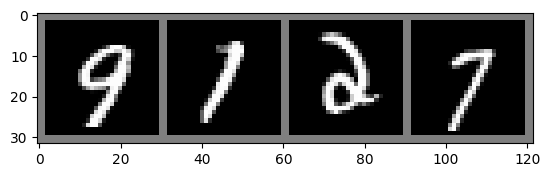

9 1 2 7


In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(batch_size)))

###Create Annotation Matrix

We create annotation matrix for each labeler L. Each labeler L will have simulated labels with dimension [num_instances] where each entry is the produced (simulated) label. Hence, the simulated labels of all labelers will be of size [L , num_instances]. Additionally, we can specify the number of spammer, noise level and the label that the spammers collectively give.


In [3]:
def simulate_labels_per_labeler(true_labels, num_labelers, num_spammers, spammer_label = 1, noise_level = 0.1):
  num_instances = len(true_labels)

  simulated_labels = np.zeros((num_labelers, num_instances), dtype = np.int)

  if num_spammers > 0:
    spammer_labels = np.full((num_spammers,num_instances), spammer_label, dtype=np.int)
    # print(simulated_labels[:num_spammers, :].shape)
    # print(spammer_labels.shape)
    simulated_labels[:num_spammers, :] = spammer_labels
  for l in range(num_spammers, num_labelers):
    for i in range(num_instances):
      # Simulate labeling decision based on true label
      if np.random.rand() < noise_level:
           # Introduce noise
           simulated_labels[l, i] = np.random.choice(np.delete(np.arange(10),
                                                                    true_labels[i]))
      else:
          # Label agrees with true label
          simulated_labels[l, i] = true_labels[i]
  return simulated_labels

def calculate_percentage_difference(simulated_labels, true_labels):
    # Create a binary matrix indicating differences for each labeler
    different_entries = (simulated_labels != true_labels).astype(int)

    # Calculate the percentage of different values for each labeler
    percentage_difference = np.mean(different_entries) * 100.0

    return different_entries, percentage_difference




In [11]:
np.random.seed(42)
torch.manual_seed(42)

# Assuming you want a subset of the data
mnist_labels = trainset.targets.numpy()


subset_size = 1000
indices = np.random.choice(len(mnist_labels), size=subset_size, replace=False)
true_labels = mnist_labels[indices]

num_labelers = 5
num_spammers = 3
num_instances = len(true_labels)
simulated_labels = simulate_labels_per_labeler(true_labels, num_labelers, num_spammers)

print(simulated_labels)


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [7 6 8 ... 6 6 2]
 [7 3 8 ... 6 8 2]]


<ipython-input-3-9d2265317d98>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  simulated_labels = np.zeros((num_labelers, num_instances), dtype = np.int)
<ipython-input-3-9d2265317d98>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional inform

## Dawid-Skene model

In [29]:
def annotation_to_count(annotations):
  instances = annotations.shape[1]
  # print(instances)
  labelers = annotations.shape[0]
  # print(labelers)
  # first determine number of classes
  classes = 10

  # initialize count array = [instances x labelers x classes]
  counts = np.zeros([instances, labelers, classes])
  # print(counts.shape)
  for n in range(instances):
    for l in range(labelers):
      vote = annotations[l,n]
      counts[n,l,vote] +=1
  return instances, labelers, classes, counts

def initialize_estimates(counts):
  """
  Formula 3.1 in Dawid-Skene (1979) to obtain true instance classes based on counts
  """
  [instances, labelers, classes] = np.shape(counts)

  instance_classes = np.zeros([instances, classes])
  sum_labelers = np.sum(counts,1)

  for n in range(instances):
    instance_classes[n,:] = sum_labelers[n,:] / np.sum(sum_labelers[n,:], dtype = float)
  return instance_classes




We start by implementing the EM algorithm

In [6]:
def m_step(counts, instance_classes):
  (dim_instances, dim_labelers, dim_classes) = counts.shape
  # calculate class marginals
  class_marginals = np.sum(instance_classes,0)/float(dim_instances)

  # initialize pi (error rates)
  error_rates = np.zeros([dim_labelers, dim_classes, dim_classes])

  # compute error rates
  for k in range(dim_labelers):
    for j in range(dim_classes):
      for l in range(dim_classes):
        error_rates[k, j, l] = np.dot(instance_classes[:,j], counts[:,k,l])
      normalizing_term = np.sum(error_rates[k,j,:])
      error_rates[k,j,:] /= float(normalizing_term)

  return error_rates, class_marginals

def e_step(counts, class_marginals, error_rates):
  # initialize instance_classes (the soft assignment of t_{n,k})
  (dim_instances, dim_labelers, dim_classes) = counts.shape

  instance_classes = np.zeros([dim_instances, dim_classes])

  for i in range(dim_instances):
    for j in range(dim_classes):
      instance_classes[i,j] = class_marginals[j] * np.prod(np.power(error_rates[:,j,:],
                                                           counts[i,:,:]))
    normalizing_term = np.sum(instance_classes[i,:])
    instance_classes[i,:] /= float(normalizing_term)
  return instance_classes

In [7]:
def run(annotations, max_tol = 0.00001, max_iter = 100):
  converged = False
  instances, labelers, classes, counts = annotation_to_count(annotations)

  # initialize instance_classes
  instance_classes = initialize_estimates(counts)
  iter = 0
  prev_class_marginals = None
  prev_error_rates = None

  # perform EM algorithm till convergens
  while not converged:
    iter +=1

    #M-step
    error_rates, class_marginals = m_step(counts, instance_classes)

    #E-step
    instance_classes = e_step(counts, class_marginals, error_rates)

    #convergence check, either difference between prev and current smaller than tol,
    # or we reached the max_iter
    if prev_class_marginals is not None:
      diff_marginals = np.sum(np.abs(class_marginals - prev_class_marginals))
      diff_error =  np.sum(np.abs(error_rates - prev_error_rates))
      # print(f'[iteration: {iter}, difference marginals: {diff_marginals}, difference error rates: {diff_error} ]')
      if(diff_marginals < max_tol and diff_error< max_tol) or iter > max_iter:
          converged = True

    # update the class_marginals and error_ratees
    prev_class_marginals = class_marginals
    prev_error_rates = error_rates

  return instance_classes


In [12]:
np.random.seed(42)
torch.manual_seed(42)

# Assuming you want a subset of the data
mnist_labels = trainset.targets.numpy()


subset_size = 1000
indices = np.random.choice(len(mnist_labels), size=subset_size, replace=False)
true_labels = mnist_labels[indices]

num_labelers = 5
num_spammers = 3
num_instances = len(true_labels)
simulated_labels = simulate_labels_per_labeler(true_labels, num_labelers, num_spammers)


instance_classes = run(simulated_labels, max_tol = 0.001, max_iter = 100)

<ipython-input-5-cb378c04e1c9>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  simulated_labels = np.zeros((num_labelers, num_instances), dtype = np.int)
<ipython-input-5-cb378c04e1c9>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional inform

(3, 1000)
(3, 1000)
[iteration: 2, difference marginals: 0.5790242607765013, difference error rates: 3.1181082624249363 ]
[iteration: 3, difference marginals: 0.1734156163631152, difference error rates: 0.5495580144197117 ]
[iteration: 4, difference marginals: 0.052745236615393445, difference error rates: 0.5475123536765639 ]
[iteration: 5, difference marginals: 0.0428553967444603, difference error rates: 0.605844938049584 ]
[iteration: 6, difference marginals: 0.03790447889489214, difference error rates: 0.5645112283230312 ]
[iteration: 7, difference marginals: 0.032761097751784596, difference error rates: 0.513709667134294 ]
[iteration: 8, difference marginals: 0.028455378985526636, difference error rates: 0.4712300918638874 ]
[iteration: 9, difference marginals: 0.023799428458713204, difference error rates: 0.4172499288676287 ]
[iteration: 10, difference marginals: 0.01822400634622777, difference error rates: 0.33765150524116416 ]
[iteration: 11, difference marginals: 0.012101218252

## Majority Voting


In [8]:
def majority_voting(simulated_labels):
 # initialize count array = [instances x labelers x classes]
 instances, labelers, classes, counts = annotation_to_count(simulated_labels)
 print(counts.shape)
 voting = np.argmax(np.sum(counts,1), axis = 1)
 return voting

### Analysis

In [30]:
np.random.seed(42)
torch.manual_seed(42)

# Assuming you want a subset of the data
mnist_labels = trainset.targets.numpy()


num_instances = 1000
indices = np.random.choice(len(mnist_labels), size=num_instances, replace=False)


# Data input
num_spammers_list = list(range(11))  # 0 to 10 spammers
num_labelers = 10
true_labels = mnist_labels[indices]
num_instances = len(true_labels)

# Data structure for storing results (list in list)
results_dawid_skene = []
results_majority_voting = []

# Number of runs per experiment
num_runs = 5

# simulated_labels = simulate_labels_per_labeler(true_labels, num_labelers, num_spammers, spammer_label = 1, noise_level = 0.1)



for num_spammers in num_spammers_list:
  # num_spammers = 2
  print(f"Running experiments with {num_spammers} spammers...")
  # Lists to store results for each run
  dawid_skene_accuracies = []
  majority_voting_accuracies = []
  # Run experiments multiple times
  for _ in range(num_runs):
      # Simulate labels
      simulated_labels = simulate_labels_per_labeler(true_labels, num_labelers, num_spammers, spammer_label=1, noise_level=0.3)
      # Dawid-Skene
      instance_classes_dawid_skene = run(simulated_labels, max_tol=0.00001, max_iter=100)
      dawid_skene_accuracy = np.mean(np.argmax(instance_classes_dawid_skene, axis = 1) == true_labels)
      dawid_skene_accuracies.append(dawid_skene_accuracy)

      # Majority Voting
      majority_voting_result = majority_voting(simulated_labels)
      majority_voting_accuracy = np.mean(majority_voting_result == true_labels)
      majority_voting_accuracies.append(majority_voting_accuracy)

  # Save results for this number of spammers
  results_dawid_skene.append(dawid_skene_accuracies)
  results_majority_voting.append(majority_voting_accuracies)

  print(f"Mean DS accuracy with {num_spammers} = {np.mean(results_dawid_skene[num_spammers]) * 100:.2f}%")
  print(f"Mean MV accuracy with {num_spammers} = {np.mean(results_majority_voting[num_spammers]) * 100:.2f}%")


# instance_classes = run(simulated_labels, max_tol = 0.001, max_iter = 100)


Running experiments with 0 spammers...


<ipython-input-3-9d2265317d98>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  simulated_labels = np.zeros((num_labelers, num_instances), dtype = np.int)


(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
Mean DS accuracy with 0 = 99.66%
Mean MV accuracy with 0 = 99.76%
Running experiments with 1 spammers...


<ipython-input-3-9d2265317d98>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  spammer_labels = np.full((num_spammers,num_instances), spammer_label, dtype=np.int)


(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
Mean DS accuracy with 1 = 99.36%
Mean MV accuracy with 1 = 99.08%
Running experiments with 2 spammers...
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
Mean DS accuracy with 2 = 98.66%
Mean MV accuracy with 2 = 96.60%
Running experiments with 3 spammers...
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
Mean DS accuracy with 3 = 97.84%
Mean MV accuracy with 3 = 84.12%
Running experiments with 4 spammers...
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
Mean DS accuracy with 4 = 96.24%
Mean MV accuracy with 4 = 48.46%
Running experiments with 5 spammers...
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
Mean DS accuracy with 5 = 93.76%
Mean MV accuracy with 5 = 12.98%
Running experiments with 6 spammers...
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
Mean DS accuracy with 6 =

<ipython-input-6-28b6c7437969>:15: RuntimeWarning: invalid value encountered in divide
  error_rates[k,j,:] /= float(normalizing_term)


(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
(1000, 10, 10)
Mean DS accuracy with 10 = 11.10%
Mean MV accuracy with 10 = 11.00%


In [5]:
# results_dawid_skene
accuracy_dawid_skene_mean = [0.9966, 0.9936, 0.9866, 0.9784, 0.9624, 0.9376, 0.8956, 0.8376, 0.6892, 0.11,
 0.111 ]
# accuracy_dawid_skene_mean = np.mean(results_dawid_skene, axis = 1 )
# print(accuracy_dawid_skene_mean)
accuracy_dawid_skene_std = [1.01980390e-03, 2.87054002e-03, 2.65329983e-03, 3.13687743e-03,
 4.07921561e-03, 4.49888875e-03, 9.85088828e-03, 4.54312668e-03,
 8.65794433e-03, 1.38777878e-17, 1.38777878e-17]
# np.std(results_dawid_skene, axis = 1)
print(accuracy_dawid_skene_std)

[0.0010198039, 0.00287054002, 0.00265329983, 0.00313687743, 0.00407921561, 0.00449888875, 0.00985088828, 0.00454312668, 0.00865794433, 1.38777878e-17, 1.38777878e-17]


In [10]:
results_majority_voting = [[0.997, 0.998, 0.997, 0.999, 0.997],
 [0.99, 0.994, 0.989, 0.988, 0.993],
 [0.973, 0.972, 0.961, 0.954, 0.97],
 [0.858, 0.832, 0.838, 0.847, 0.831],
 [0.506, 0.494, 0.477, 0.471, 0.475],
 [0.134, 0.128, 0.128, 0.131, 0.128],
 [0.11, 0.11, 0.11, 0.11, 0.11],
 [0.11, 0.11, 0.11, 0.11, 0.11],
 [0.11, 0.11, 0.11, 0.11, 0.11],
 [0.11, 0.11, 0.11, 0.11, 0.11],
 [0.11, 0.11, 0.11, 0.11, 0.11]]

accuracy_majority_voting_mean = np.mean(results_majority_voting, axis = 1 )
print(accuracy_majority_voting_mean)
accuracy_majority_voting_std = np.std(results_majority_voting, axis = 1 )

[0.9976 0.9908 0.966  0.8412 0.4846 0.1298 0.11   0.11   0.11   0.11
 0.11  ]


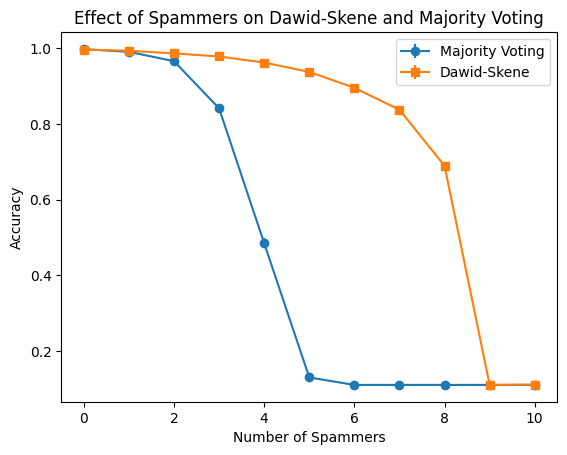

In [11]:
# Replace these lists with your actual data
num_spammers = list(range(11))
# accuracy_majority_voting_mean = [0.90, 0.85, 0.80, 0.75, 0.70]
# accuracy_majority_voting_std = [0.02, 0.03, 0.04, 0.02, 0.03]  # Example standard deviation data
# accuracy_dawid_skene_mean = [0.92, 0.88, 0.85, 0.78, 0.72]
# accuracy_dawid_skene_std = [0.01, 0.02, 0.03, 0.02, 0.01]  # Example standard deviation data

plt.errorbar(num_spammers, accuracy_majority_voting_mean, yerr=accuracy_majority_voting_std, label='Majority Voting', marker='o')
plt.errorbar(num_spammers, accuracy_dawid_skene_mean, yerr=accuracy_dawid_skene_std, label='Dawid-Skene', marker='s')

plt.xlabel('Number of Spammers')
plt.ylabel('Accuracy')
plt.title('Effect of Spammers on Dawid-Skene and Majority Voting')
plt.legend()
plt.show()

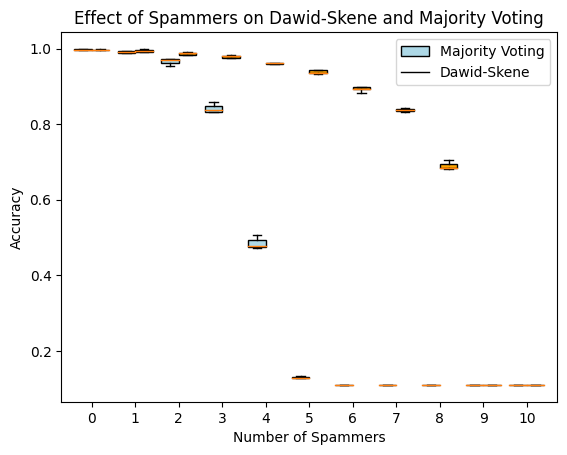

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Replace these lists with your actual data
num_spammers = list(range(11))
accuracy_majority_voting_all_runs = results_majority_voting
accuracy_dawid_skene_all_runs = results_dawid_skene

# Set colors for boxplots
majority_voting_color = 'lightblue'
dawid_skene_color = 'orange'

plt.boxplot(accuracy_majority_voting_all_runs, positions=np.array(num_spammers) - 0.2, widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor=majority_voting_color))
plt.boxplot(accuracy_dawid_skene_all_runs, positions=np.array(num_spammers) + 0.2, widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor=dawid_skene_color))

plt.xlabel('Number of Spammers')
plt.ylabel('Accuracy')
plt.title('Effect of Spammers on Dawid-Skene and Majority Voting')
plt.xticks(num_spammers, num_spammers)
plt.legend(['Majority Voting', 'Dawid-Skene'])

plt.show()

In [ ]:
print(np.argmax(instance_classes[0]))
print(true_labels[0])
# Calculate percentage difference and create binary matrix
simulated_labels_first = simulated_labels[2]
different_entries, percentage_difference = calculate_percentage_difference(simulated_labels_first, true_labels)

# Print percentage difference
print(f"Percentage of different values: {percentage_difference:.2f}%")

7
7
Percentage of different values: 89.00%
